In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 

sns.set_style(style='white')
sns.set_context(context ='paper')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='C:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

font_path = 'font/NanumSquareRoundR.ttf'
fontprop = font_manager.FontProperties(fname=font_path)

pd.set_option('display.max_columns',999)

In [4]:
product = pd.read_csv('data/Product.csv')
search1 = pd.read_csv('data/Search1.csv')
search2 = pd.read_csv('data/Search2.csv')
session = pd.read_csv('data/Session.csv')
master = pd.read_csv('data/Master.csv')
custom = pd.read_csv('data/Custom.csv')

C:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# product 이상치 제거
product = product[lambda x : x.HITS_SEQ != 1]

# 똑같은 row 지우기
product.drop_duplicates(inplace = True)
session.drop_duplicates(inplace = True)
search1.drop_duplicates(inplace = True)
search2.drop_duplicates(inplace = True)
master.drop_duplicates(inplace = True)
custom.drop_duplicates(inplace = True)

# 4. 상품군별 선호지수

## data 준비

In [4]:
score_df = pd.read_csv('data/final_df_formodeling_RF.csv')
score_df.head(1)

,CLNT_ID,SESS_ID,SESS_DT,HITS_SEQ,SESS_SEQ,TOT_SESS_HR_V,PD_BUY_TO,DVC_CTG_NM,ZON_NM,CLNT_GENDER,CLNT_AGE,MONTH,DAY,WEEKDAY,SEARCH_CNT,ONE_PAG_HR_V,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8
0,8,6964877,20180606,3.866404,2.192006,9.248459,20.106578,0,0,0,0,6,0,2,0,1.935502,-0.039979,0.082366,0.853637,0.271311,0.19387,0.043454,-0.002416,-0.01031


## FE

In [5]:
score_df = score_df[['CLNT_ID', 'SESS_ID', 'HITS_SEQ', 'SESS_SEQ',
       'TOT_SESS_HR_V', 'PD_BUY_TO', 'DVC_CTG_NM', 'ZON_NM', 'CLNT_GENDER',
       'CLNT_AGE']]

In [6]:
cluster_df = score_df.sample(frac = 0.05,random_state = 0).reset_index(drop = True)
len(cluster_df)

127055

## 상품군 clustering 와 RF importance를 통한 변수 추출

- kmeans

In [7]:
numeric_list = ['SESS_SEQ','HITS_SEQ','TOT_SESS_HR_V','PD_BUY_TO']

In [8]:
# scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
cluster_df_scale = cluster_df[numeric_list]

scaled_df = pd.DataFrame(scaler.fit_transform(cluster_df_scale), columns = cluster_df_scale.columns)

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Sum_of_squared_distances = []
X = np.array(scaled_df[numeric_list])
sil_coeff = list()
    
K = [2,4,6,8,10]
for k in K:
    
    km = KMeans(n_clusters=k,random_state=0)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    
    label = km.labels_
    sil_coeff.append(silhouette_score(X, label, metric='euclidean'))

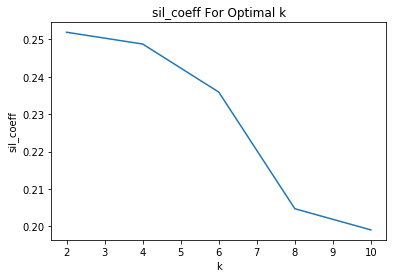

In [29]:
plt.plot(K, sil_coeff)
plt.xlabel('k')
plt.ylabel('sil_coeff')
plt.title('sil_coeff For Optimal k')
plt.show()

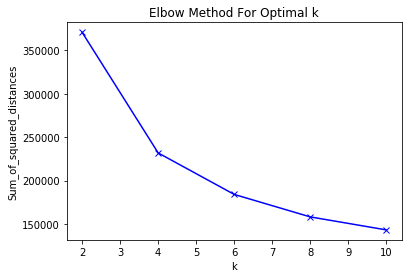

In [30]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

- 클러스터의 갯수는 6

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
X = np.array(scaled_df[numeric_list])

kmeans = KMeans(n_clusters=6, random_state = 42).fit(X)
scaled_df['numeric_labels'] = kmeans.labels_
X1 = scaled_df[numeric_list]
y1 = scaled_df.numeric_labels
RF1 = RandomForestClassifier(n_estimators = 100)
RF1.fit(X1,y1)
pd.DataFrame(RF1.feature_importances_)

,0
0,0.278624
1,0.270044
2,0.285304
3,0.166028


- kmodes : kmodes 는 k 갯수를 정하는 방법론이 없어서 k를 여러개 해서 importance를 살표보았다.

In [34]:
categoric_list = ['DVC_CTG_NM', 'ZON_NM', 'CLNT_GENDER', 'CLNT_AGE']

In [36]:
from kmodes.kmodes import KModes

X = np.array(cluster_df[categoric_list])
imp_list2 = list()
for k in  [2,3,4,5,6,7]:
    kmodes = KModes(n_clusters=k, init='Huang',n_init=2).fit(X)
    cluster_df['categoric_labels'] = kmodes.labels_
    X2 = cluster_df[categoric_list]
    y2 = cluster_df.categoric_labels
    RF2 = RandomForestClassifier(n_estimators = 100)
    RF2.fit(X2,y2)
    imp_list2.append(RF2.feature_importances_)

In [37]:
pd.DataFrame(imp_list2, columns =categoric_list)

,DVC_CTG_NM,ZON_NM,CLNT_GENDER,CLNT_AGE
0,0.001342,0.433592,0.000587,0.564479
1,0.001070,0.336095,0.000398,0.662436
2,0.001035,0.496796,0.000351,0.501818
3,0.001420,0.563965,0.086555,0.348061
4,0.212091,0.414820,0.000340,0.372748
5,0.001362,0.566748,0.042804,0.389086


In [39]:
pd.DataFrame(imp_list2, columns =categoric_list).mean()

DVC_CTG_NM     0.036387
ZON_NM         0.468670
CLNT_GENDER    0.021839
CLNT_AGE       0.473105
dtype: float64

## 선호지수 예시

In [6]:
score1_list = ['TOT_SESS_HR_V']
score2_list = ['CLNT_AGE']

In [7]:
final_df = pd.read_csv('data/time_df_RF.csv')
final_df.head()

,CLNT_ID,SESS_ID,SESS_DT,HITS_SEQ,SESS_SEQ,TOT_SESS_HR_V,PD_BUY_TO,DVC_CTG_NM,ZON_NM,CLNT_GENDER,CLNT_AGE,MONTH,DAY,WEEKDAY,SEARCH_CNT,ONE_PAG_HR_V
0,8,6964877,20180606,40.0,7.0,366.0,38000,mobile,Gyeonggi-do,M,young,6,first,2,0,9.631579
1,8,7017688,20180605,74.0,2.0,468.0,38000,mobile,Seoul,M,young,6,first,1,0,8.509091
2,14,1156991,20180911,284.0,5.0,7098.0,69800,mobile,Gyeonggi-do,F,30.0,9,second,1,1,27.726562
3,32,759569,20180917,37.0,105.0,1098.0,19800,mobile,city,M,40.0,9,second,0,0,8.854839
4,32,1136737,20180911,72.0,99.0,2883.0,57000,mobile,city,M,40.0,9,second,1,0,35.592593


In [8]:
temp_product = product[['CLNT_ID','SESS_ID','PD_C']]
temp_product.drop_duplicates(inplace = True)

temp_merge = pd.merge(temp_product, master[['PD_C','CLAC1_NM']], how = 'left')
temp_merge = temp_merge[['CLNT_ID','SESS_ID','CLAC1_NM']]
temp_merge.drop_duplicates(inplace = True)

temp_count = temp_merge.groupby(['CLNT_ID','SESS_ID']).count().reset_index()

association_df = pd.merge(temp_count[lambda x : x.CLAC1_NM == 1][['CLNT_ID','SESS_ID']], temp_merge, how = 'left', on = ['CLNT_ID','SESS_ID'])

C:\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [9]:
association_df.head(1)

,CLNT_ID,SESS_ID,CLAC1_NM
0,8,6964877,패션잡화


In [10]:
temp_df = pd.merge(association_df, final_df[score1_list + score2_list+['CLNT_ID','SESS_ID']], how = 'left', on = ['CLNT_ID','SESS_ID'])

In [11]:
temp_df.head(1)

,CLNT_ID,SESS_ID,CLAC1_NM,TOT_SESS_HR_V,CLNT_AGE
0,8,6964877,패션잡화,366.0,young


### 소비자 행동지수

In [12]:
def 행동선호지수(tot_sess_hr_v) : 
    
    temp_score1 = temp_df.groupby('CLAC1_NM')[score1_list].mean().reset_index()
    
    def score_TOT_SESS_HR_V(tot_sess_hr_v):
        cut2 = temp_score1['TOT_SESS_HR_V'].quantile(0.20) 
        cut1 = temp_score1['TOT_SESS_HR_V'].quantile(0.80)
        
        if tot_sess_hr_v > cut1: 
            return temp_score1[lambda x: x.TOT_SESS_HR_V > cut1].CLAC1_NM.tolist()
        elif (tot_sess_hr_v > cut2 and tot_sess_hr_v < cut1) :
            return temp_score1[lambda x: cut2 < x.TOT_SESS_HR_V < cut1].CLAC1_NM.tolist()
        else : 
            return temp_score1[lambda x: x.TOT_SESS_HR_V < cut2].CLAC1_NM.tolist()
    
    def score1(x):
        if x in TOT_SESS_HR_V_list: return 1
        else : return 0
        
    TOT_SESS_HR_V_list = score_TOT_SESS_HR_V(tot_sess_hr_v)
    
    temp_score1['행동선호지수'] = temp_score1.CLAC1_NM.map(score1)
    
    return temp_score1.sort_values('행동선호지수', ascending = False).reset_index(drop=True)

In [19]:
행동선호지수(366.0).head(1)

,CLAC1_NM,TOT_SESS_HR_V,행동선호지수
0,완구,991.131129,1


### 소비자 상태지수

In [14]:
def 상태선호지수(clnt_age):
    
    age_ = temp_df.groupby('CLNT_AGE')['CLAC1_NM'].value_counts() / temp_df.groupby('CLNT_AGE')['CLAC1_NM'].count()
    age_df = pd.DataFrame(age_)
    age_df.columns = ['비율']
    age_df.reset_index(inplace = True)
    temp_score2 = age_df[age_df.CLNT_AGE == clnt_age].sort_values('비율', ascending = False).reset_index(drop = True)
    age_list = temp_score2.CLAC1_NM[:7].tolist()

    def score2(x):
        if x in age_list: return 1
        else : return 0
        
    temp_score2['상태선호지수'] = temp_score2.CLAC1_NM.map(score2)
    return temp_score2

In [15]:
상태선호지수('young').head(1)

,CLNT_AGE,CLAC1_NM,비율,상태선호지수
0,young,화장품/뷰티케어,0.26789,1


### 소비자 구매지수

In [16]:
def 상품군구매지수(product):
    temp_score3 = pd.DataFrame(np.arange(len(master.CLAC1_NM.unique())),master.CLAC1_NM.unique())
    temp_score3.reset_index(inplace = True)
    temp_score3.columns = ['CLAC1_NM', 'score3_final']      

    def score3(x):
        if x == product : return 1
        else : return 0

    temp_score3['상품군구매지수'] = temp_score3.CLAC1_NM.map(score3)
    return temp_score3[['CLAC1_NM', '상품군구매지수']]

In [17]:
상품군구매지수('패션잡화').head(1)

,CLAC1_NM,상품군구매지수
0,스포츠패션,0


### 상품군선호지수

In [20]:
def 상품군선호지수(tot_sess_hr_v,clnt_age,product):
    
    def 소비자행동지수(tot_sess_hr_v) : 
        temp_score1 = temp_df.groupby('CLAC1_NM')[score1_list].mean().reset_index()
        def score_TOT_SESS_HR_V(tot_sess_hr_v):
            cut2 = temp_score1['TOT_SESS_HR_V'].quantile(0.20) 
            cut1 = temp_score1['TOT_SESS_HR_V'].quantile(0.80)
            if tot_sess_hr_v > cut1: 
                return temp_score1[lambda x: x.TOT_SESS_HR_V > cut1].CLAC1_NM.tolist()
            elif (tot_sess_hr_v > cut2 and tot_sess_hr_v < cut1) :
                return temp_score1[lambda x: cut2 < x.TOT_SESS_HR_V < cut1].CLAC1_NM.tolist()
            else : 
                return temp_score1[lambda x: x.TOT_SESS_HR_V < cut2].CLAC1_NM.tolist()
        def score1(x):
            if x in TOT_SESS_HR_V_list: return 1
            else : return 0
        TOT_SESS_HR_V_list = score_TOT_SESS_HR_V(tot_sess_hr_v)
        temp_score1['소비자행동지수'] = temp_score1.CLAC1_NM.map(score1)
        return temp_score1.sort_values('소비자행동지수', ascending = False).reset_index(drop=True)

    def 소비자상태지수(clnt_age):
        age_ = temp_df.groupby('CLNT_AGE')['CLAC1_NM'].value_counts() / temp_df.groupby('CLNT_AGE')['CLAC1_NM'].count()
        age_df = pd.DataFrame(age_)
        age_df.columns = ['비율']
        age_df.reset_index(inplace = True)
        temp_score2 = age_df[age_df.CLNT_AGE == clnt_age].sort_values('비율', ascending = False).reset_index(drop = True)
        age_list = temp_score2.CLAC1_NM[:7].tolist()
        def score2(x):
            if x in age_list: return 1
            else : return 0
        temp_score2['소비자상태지수'] = temp_score2.CLAC1_NM.map(score2)
        return temp_score2
    
    def 소비자구매지수(product):
        temp_score3 = pd.DataFrame(np.arange(len(master.CLAC1_NM.unique())),master.CLAC1_NM.unique())
        temp_score3.reset_index(inplace = True)
        temp_score3.columns = ['CLAC1_NM', 'score3_final']      
        def score3(x):
            if x == product : return 1
            else : return 0
        temp_score3['소비자구매지수'] = temp_score3.CLAC1_NM.map(score3)
        return temp_score3[['CLAC1_NM', '소비자구매지수']]

    df1 = 소비자행동지수(tot_sess_hr_v)
    df2 = 소비자상태지수(clnt_age)
    df3 = 소비자구매지수(product)
    
    df = pd.merge(df1, df2, on = 'CLAC1_NM')
    df = pd.merge(df, df3, on = 'CLAC1_NM')
    df = df[['CLAC1_NM','소비자행동지수','소비자상태지수','소비자구매지수']]
    df['상품군선호지수'] = df.소비자행동지수 * 0.25 + df.소비자상태지수 * 0.25 + df.소비자구매지수 * 0.5
    return df.sort_values('상품군선호지수', ascending = False)

In [21]:
상품군선호지수(366,'young','패션잡화')

,CLAC1_NM,소비자행동지수,소비자상태지수,소비자구매지수,상품군선호지수
17,패션잡화,0,1,1,0.75
2,퍼스널케어,1,1,0,0.50
0,완구,1,0,0,0.25
32,남성의류,0,1,0,0.25
26,속옷/양말/홈웨어,0,1,0,0.25
25,스포츠패션,0,1,0,0.25
21,여성의류,0,1,0,0.25
1,세제/위생,1,0,0,0.25
36,화장품/뷰티케어,0,1,0,0.25
3,컴퓨터,1,0,0,0.25
